In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit

In [2]:
test = pd.read_csv("Data/test.csv")
stores = pd.read_csv("Data/stores.csv")
train = pd.read_csv("Data/train.csv")

In [3]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


<Axes: xlabel='date'>

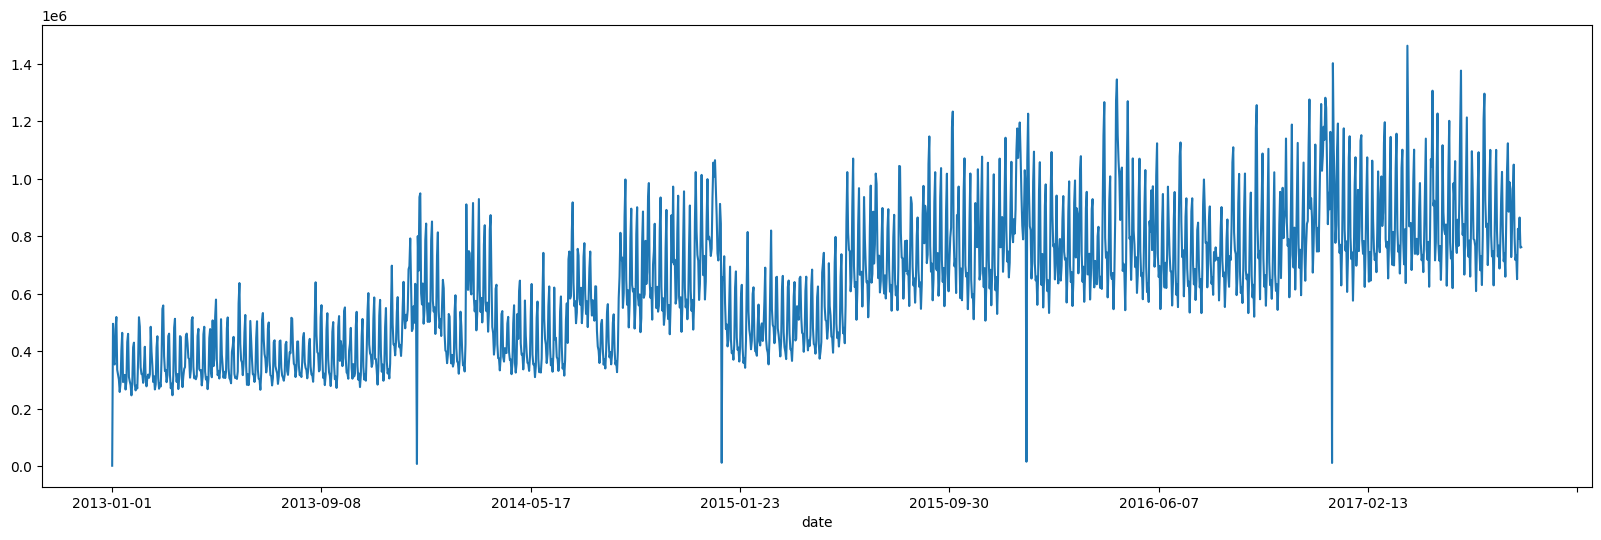

In [4]:
train.groupby("date").sum()["sales"].plot(figsize = (20,6))

In [5]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
[(df['month'].eq(1)) & (df['day'].eq(1))]

NameError: name 'df' is not defined

In [232]:
df.family.value_counts()

family
AUTOMOTIVE                    90936
BABY CARE                     90936
BEAUTY                        90936
BEVERAGES                     90936
BOOKS                         90936
BREAD/BAKERY                  90936
CELEBRATION                   90936
CLEANING                      90936
DAIRY                         90936
DELI                          90936
EGGS                          90936
FROZEN FOODS                  90936
GROCERY I                     90936
GROCERY II                    90936
HARDWARE                      90936
HOME AND KITCHEN I            90936
HOME AND KITCHEN II           90936
HOME APPLIANCES               90936
HOME CARE                     90936
LADIESWEAR                    90936
LAWN AND GARDEN               90936
LINGERIE                      90936
LIQUOR,WINE,BEER              90936
MAGAZINES                     90936
MEATS                         90936
PERSONAL CARE                 90936
PET SUPPLIES                  90936
PLAYERS AND ELECTRONI

In [235]:
df = train.merge(stores, on = "store_nbr")
np.where(df["family"].isin(["BREAD/BAKERY", "DAIRY", "DELI", "EGGS","FROZEN FOODS","GROCERY I", "GROCERY II", "MEATS", "POULTRY","PREPARED FOODS", "PRODUCE","SEAFOOD"]), "Food", "not food")

array(['not food', 'not food', 'not food', ..., 'Food', 'not food',
       'Food'], shape=(3000888,), dtype='<U8')

In [10]:
def data_pipline(df, cat_feat):
    df = df.merge(stores, on = "store_nbr")
    df['month'] = pd.to_datetime(df['date']).dt.month.astype('category')
    # Assign column for first day of the year
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['day'] = pd.to_datetime(df['date']).dt.day
    df['new_years_day'] = np.where((df['month'] == 1) & (df['day'] == 1), 1, 0)
    df['month'] = df['month'].astype('category')
    df["broad_cat"] = np.where(df["family"].isin(["BREAD/BAKERY", "DAIRY", "DELI", "EGGS","FROZEN FOODS","GROCERY I", "GROCERY II", "MEATS", "POULTRY","PREPARED FOODS", "PRODUCE","SEAFOOD"]), "Food", "not food")
    X = df[["onpromotion","new_years_day","month"]]
    X = df[["new_years_day"]]
    y = df.loc[:,"sales"]
    
    # Create a TimeSeriesSplit object
    tscv = TimeSeriesSplit(n_splits=2)
    
    # Iterate over the splits
    for train_index, test_index in tscv.split(X):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    display(X_train.head())
    # display(X_test.head())
    categorical_features = cat_feat
    transformer = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), categorical_features)], remainder='passthrough')
    # display(X.head())
    X_train = transformer.fit_transform(X_train)
    X_test = transformer.fit_transform(X_test)
    return X_train, X_test, y_train, y_test

In [21]:
def lin_mod(train, test):
    # Prepare the training data
    X_train, X_test, y_train, y_test = data_pipline(train, ["month"])

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    # Access the coefficients
    coefficients = model.coef_
    intercept = model.intercept_
    # model.
    print("Coefficients:", coefficients)
    print("Intercept:", intercept)
    # s
    # X_test = data_pipline(test,["family", "city"])
    y_pred = pd.Series(model.predict(X_test))
    print(y_pred.head())
    
    return y_pred, X_train, X_test, y_train, y_test

In [22]:
y_pred, X_train, X_test, y_train, y_test = lin_mod(train,test)

,new_years_day
0,1
1,1
2,1
3,1
4,1


,new_years_day
2000592,0
2000593,0
2000594,0
2000595,0
2000596,0


Coefficients: [-302.42178072]
Intercept: 308.07844393459663
0    308.078444
1    308.078444
2    308.078444
3    308.078444
4    308.078444
dtype: float64


In [13]:
y_pred

0          308.078444
1          308.078444
2          308.078444
3          308.078444
4          308.078444
              ...    
1000291    308.078444
1000292    308.078444
1000293    308.078444
1000294    308.078444
1000295    308.078444
Length: 1000296, dtype: float64

<Axes: >

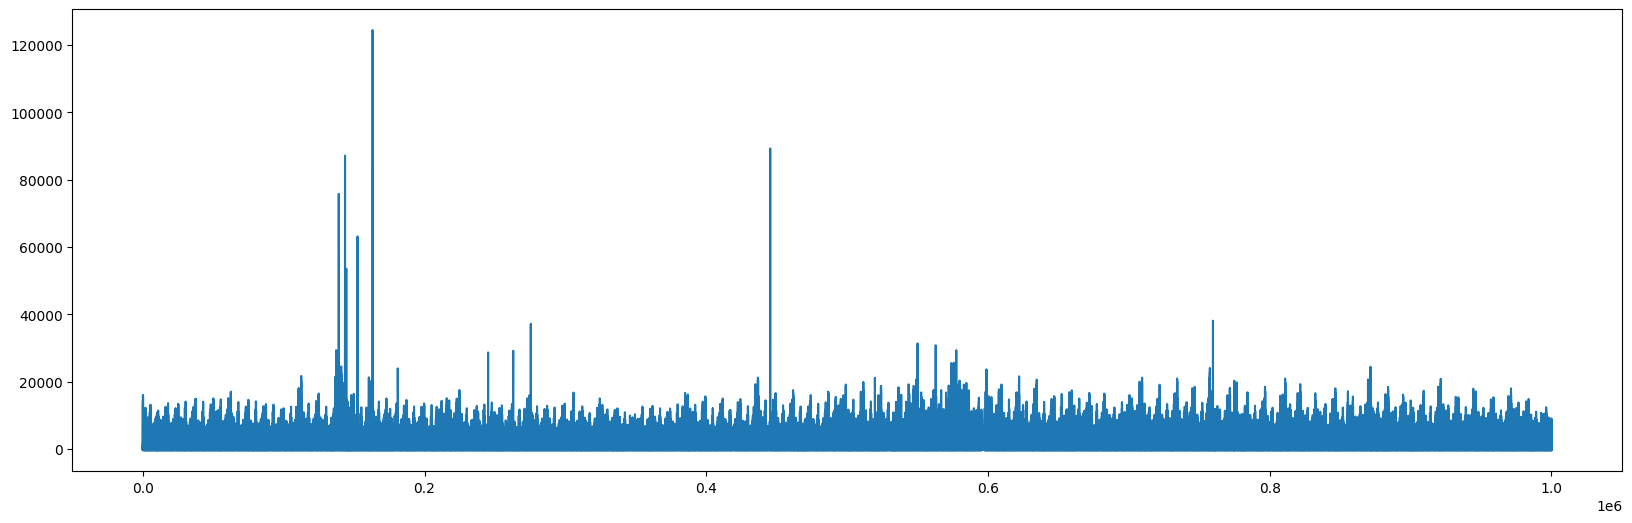

In [18]:
resid = pd.DataFrame(y_test).reset_index(drop = True)
resid['y_hat'] = y_pred
resid['resid'] = resid['sales'] - resid['y_hat']
resid['resid'].plot(figsize = (20,6))

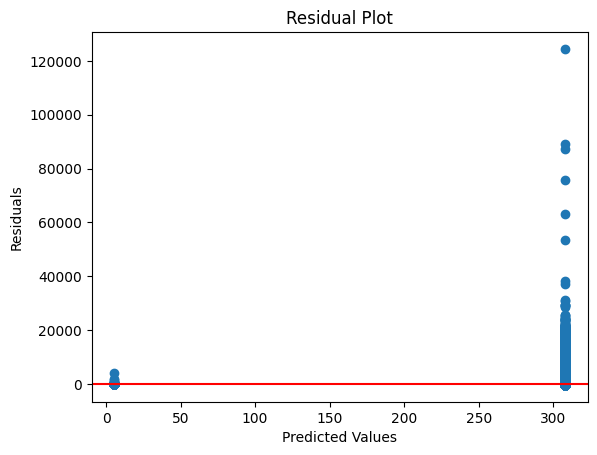

In [19]:
plt.scatter(y_pred, resid['resid'])
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='-')
plt.title("Residual Plot")
plt.show()

In [77]:
submission = pd.DataFrame(test["id"])
submission ["sales"] = y_pred
submission.to_csv("submission.csv", index = False)

In [139]:
transactions = pd.read_csv("Data/transactions.csv")
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [140]:
transactions.shape

(83488, 3)

In [141]:
train.shape

(3000888, 10)

In [9]:
store_trans = transactions.merge(stores, on = "store_nbr")
# store_trans[["store_nbr", "type"]].value_counts()
store_trans

,date,store_nbr,transactions,city,state,type,cluster
0,2013-01-01,25,770,Salinas,Santa Elena,D,1
1,2013-01-02,1,2111,Quito,Pichincha,D,13
2,2013-01-02,2,2358,Quito,Pichincha,D,13
3,2013-01-02,3,3487,Quito,Pichincha,D,8
4,2013-01-02,4,1922,Quito,Pichincha,D,9
...,...,...,...,...,...,...,...
83483,2017-08-15,50,2804,Ambato,Tungurahua,A,14
83484,2017-08-15,51,1573,Guayaquil,Guayas,A,17
83485,2017-08-15,52,2255,Manta,Manabi,A,11
83486,2017-08-15,53,932,Manta,Manabi,D,13


In [8]:
train.merge(transactions, on = ["date", "store_nbr"])

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions
0,561,2013-01-01,25,AUTOMOTIVE,0.000,0,Salinas,Santa Elena,D,1,770
1,562,2013-01-01,25,BABY CARE,0.000,0,Salinas,Santa Elena,D,1,770
2,563,2013-01-01,25,BEAUTY,2.000,0,Salinas,Santa Elena,D,1,770
3,564,2013-01-01,25,BEVERAGES,810.000,0,Salinas,Santa Elena,D,1,770
4,565,2013-01-01,25,BOOKS,0.000,0,Salinas,Santa Elena,D,1,770
...,...,...,...,...,...,...,...,...,...,...,...
2755099,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,2155
2755100,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,2155
2755101,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,2155
2755102,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,2155


In [138]:
transactions

NameError: name 'transactions' is not defined